In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Для жадного перебора
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

In [3]:
# Для отображения графики
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
#HTML(style)

## Загрузка данных

In [14]:
# Загружаю датасет из своей директории
data = pd.read_csv("https://raw.githubusercontent.com/Quantanomo/data_sets/master/BlackFriday.csv", na_values="NaN")

## Предобработка

In [15]:
# Удаляю ненужные столбцы
data.drop(['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3'], axis = 1, inplace = True)

# Группирую по пользователям сумму покупок и удаляю User_id
col_names = data.iloc[:,:-1].columns.tolist()
data_new = data.groupby(col_names).agg('sum').reset_index()
data_new.drop(columns = 'User_ID', inplace = True)

data_new.Gender.replace(['F', 'M'], [0,1], inplace = True)
data_new.Age.replace(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'], [1, 2, 3, 4, 5, 6, 7], inplace = True)
data_new.Stay_In_Current_City_Years.replace(['0', '1', '2', '3', '4+'], [1,2,3,4,5], inplace = True)
data_new = data_new.drop(columns = 'City_Category').join(pd.get_dummies(data_new.City_Category))

step = round((data_new.Purchase.max() - data_new.Purchase.min()) / 5).astype('int')
    
data_new = data_new.assign(Cat_Purchase = 0)
data_new.loc[data_new.Cat_Purchase < 2142643, 'Cat_Purchase'] = 1
data_new.loc[(data_new.Purchase >= 2142643) & (data_new.Purchase < 4241178), 'Cat_Purchase'] = 2
data_new.loc[(data_new.Purchase >= 4241178) & (data_new.Purchase < 6339713), 'Cat_Purchase'] = 3
data_new.loc[(data_new.Purchase >= 6339713) & (data_new.Purchase < 8438248), 'Cat_Purchase'] = 4
data_new.loc[data_new.Purchase >= 8438248, 'Cat_Purchase'] = 5

data_new.drop(columns = 'Purchase', inplace = True)

data_new.Cat_Purchase.value_counts()

1    5364
2     456
3      62
4       7
5       2
Name: Cat_Purchase, dtype: int64

In [16]:
# Уровняю группы за счет добавления дублей
max_size = data_new['Cat_Purchase'].value_counts().max()
lst = [data_new]
for class_index, group in data_new.groupby('Cat_Purchase'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)

frame_new.Cat_Purchase.value_counts()

5    5364
4    5364
3    5364
2    5364
1    5364
Name: Cat_Purchase, dtype: int64

## Простая модель

In [17]:
# Разделю данные на train и test в пропорции 0,75/0,25
x = frame_new.drop('Cat_Purchase', axis=1)
y = frame_new.Cat_Purchase

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state=42)

In [19]:
# Создам модель дерева с дефолтными настройками
dt = DecisionTreeClassifier()

# Определю параметры для теста лучшей модели
parametrs = {'criterion': ['gini', 'entropy'],
             'max_depth': range(1,4), 
             'min_samples_split': range(2,4), 
             'min_samples_leaf': range(1,6)}

In [20]:
# Найду модель с лучшим качеством. Буду использовать жадный алгоритм перебора параметров. 
# Если необходимо быстро, но не точно - использую RandomizedSearchCV
search = GridSearchCV(dt, parametrs, cv=5)
search.fit(x_train,y_train)

# Определим лучшую модель
best_tree = search.best_estimator_

In [21]:
# Прогнозирую класс на тестовой выборке
predicted = best_tree.predict(x_test)

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

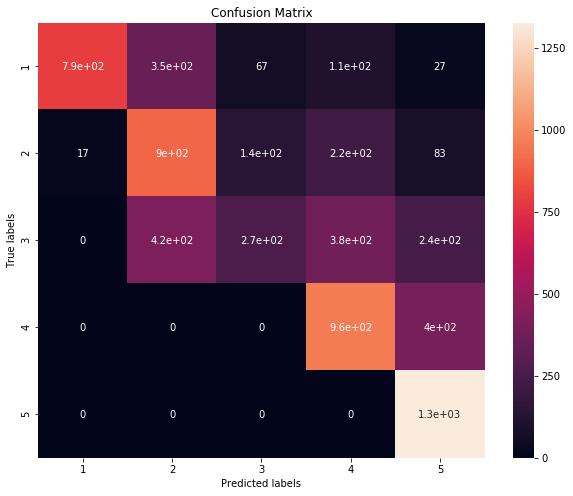

In [30]:
# Строю матрицу ошибок
df = confusion_matrix(y_test,predicted)

# Визуализируем матрицу
plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(df, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['1','2','3','4','5'])
ax.yaxis.set_ticklabels(['1','2','3','4','5'])

In [31]:
# Смотрю точность модели
print('Точность модели:', accuracy_score(y_test,predicted))

Точность модели: 0.6320656226696495


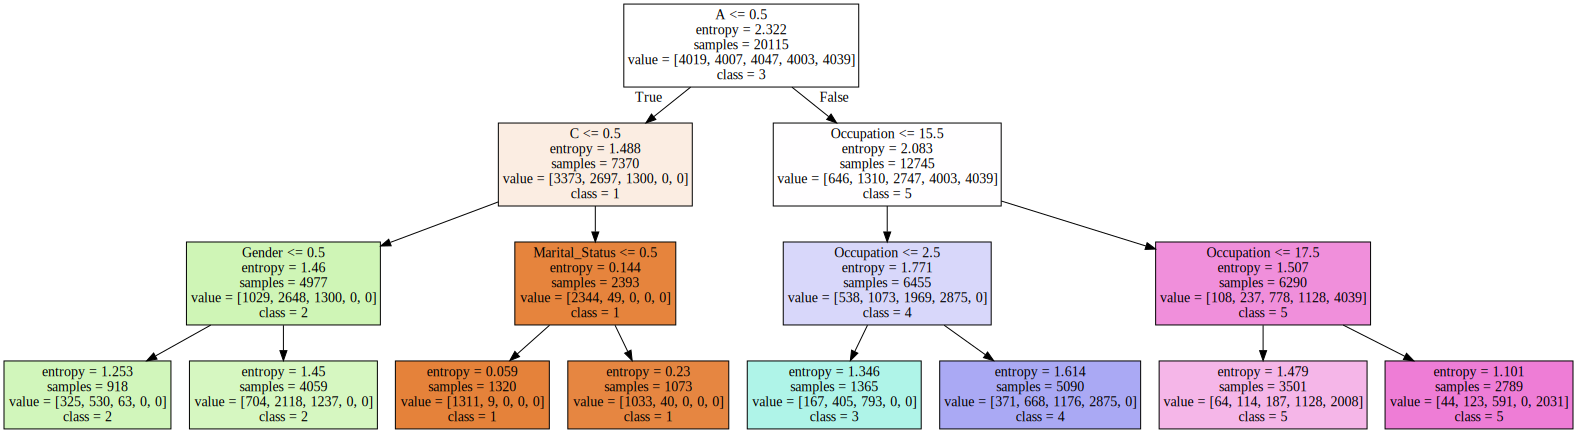

In [42]:
# Визуализация дерева
graph = Source(export_graphviz(best_tree, out_file=None
                                   , feature_names = list(x), class_names=['1','2','3','4','5']
                                   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [43]:
graph = Source(export_graphviz(best_tree, out_file=None
                                   , feature_names = list(x), class_names=['1','2','3','4','5']
                                   , filled = True))
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

## Модель посложнее

In [50]:
# Создам модель дерева с дефолтными настройками
dt = DecisionTreeClassifier()

# Определю параметры для теста лучшей модели
parametrs = {'criterion': ['gini', 'entropy'],
             'max_depth': range(10,25), 
             'min_samples_split': range(2,8), 
             'min_samples_leaf': range(1,5)}

In [51]:
# Найду модель с лучшим качеством. Буду использовать жадный алгоритм перебора параметров. 
# Если необходимо быстро, но не точно - использую RandomizedSearchCV
search = GridSearchCV(dt, parametrs, cv=5)
search.fit(x_train,y_train)

# Определим лучшую модель
best_tree = search.best_estimator_

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

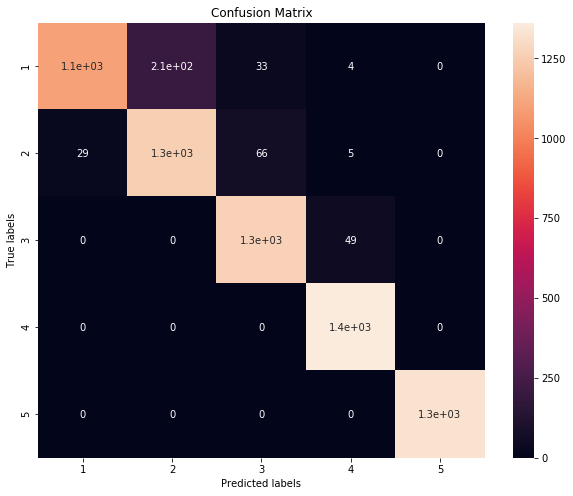

In [52]:
# Прогнозирую класс на тестовой выборке
predicted = best_tree.predict(x_test)

# Строю матрицу ошибок
df = confusion_matrix(y_test,predicted)

# Визуализируем матрицу
plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(df, annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['1','2','3','4','5'])
ax.yaxis.set_ticklabels(['1','2','3','4','5'])

In [53]:
# Смотрю точность модели
print('Точность модели:', accuracy_score(y_test,predicted))

Точность модели: 0.9413870246085011


In [54]:
graph = Source(export_graphviz(best_tree, out_file=None
                                   , feature_names = list(x), class_names=['1','2','3','4','5']
                                   , filled = True))
graph.format = 'png'
graph.render('dtree_render_2',view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.504317 to fit


'dtree_render_2.png'